In [39]:
import pandas as pd
import lightgbm
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('bank-additional-full.csv', delimiter=";", quotechar="'").replace('"', value='', regex=True)

In [3]:
df.columns = df.columns.str.replace('"','')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  object 
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [7]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [11]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [31]:
df[df.isna().any(axis=1)]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y


In [115]:
for col in df.columns[:-1]:
    fig = plt.figure(figsize=(10, 6))
    plt.hist(x=df[col], edgecolor='black')
    plt.title(col + '\nDistinct values: ' + str(len(df[col].unique())))
    plt.savefig('plots\\' + col + '.png', dpi=300)
    plt.close()

In [33]:
cat_columns = ['job', 'marital', 'education', 'default', 'contact', 'housing', 'loan', 'day_of_week', 'month', 'poutcome']
val_columns = ['age', 'campaign', 'cons.conf.idx', 'cons.price.idx', 'duration', 'emp.var.rate', 'euribor3m', 'nr.employed', 'pdays', 'previous']

In [34]:
for col in cat_columns:
    df[col] = df[col].astype(str)

for col in val_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [41]:
df_no_onehot = df

In [60]:
df_corr = pd.get_dummies(df, drop_first=False).corr()

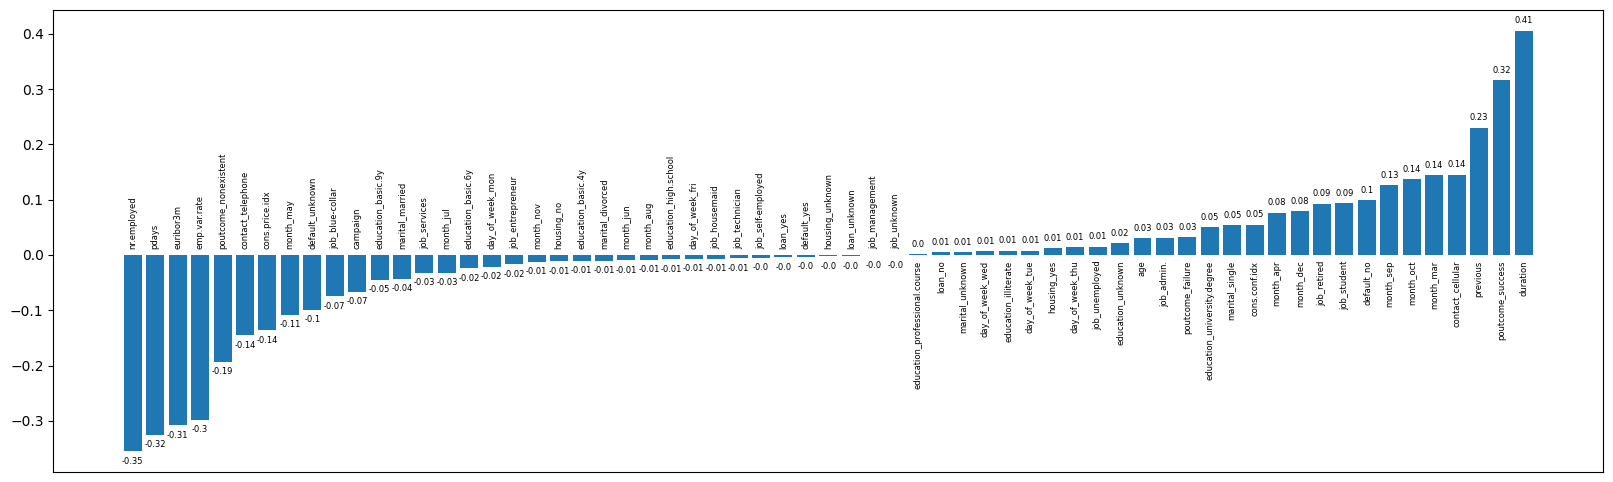

In [114]:
sorted_df = df_corr['y_yes'].sort_values()[1:-1]

plt.figure(figsize=(20, 6))

bars = plt.bar(x=sorted_df.index, height=sorted_df, width=0.8)

for idx, bar in enumerate(bars):
    yval = bar.get_height()
    cat = sorted_df.index[idx]
    if yval >= 0:
        va_val = 'bottom'
        va_val2 = 'top'
        offset = 0.01
    else:
        va_val = 'top'
        va_val2 = 'bottom'
        offset = -0.01
    plt.text(bar.get_x() + bar.get_width()/2, yval + offset, round(yval, 2), va=va_val, ha='center', fontsize=6)
    plt.text(bar.get_x() + bar.get_width()/2, 0 - offset, cat, va=va_val2, ha='center', fontsize=6, rotation=90)

plt.xticks([])
plt.savefig('plots\\correlation.png', dpi=300)
plt.show()

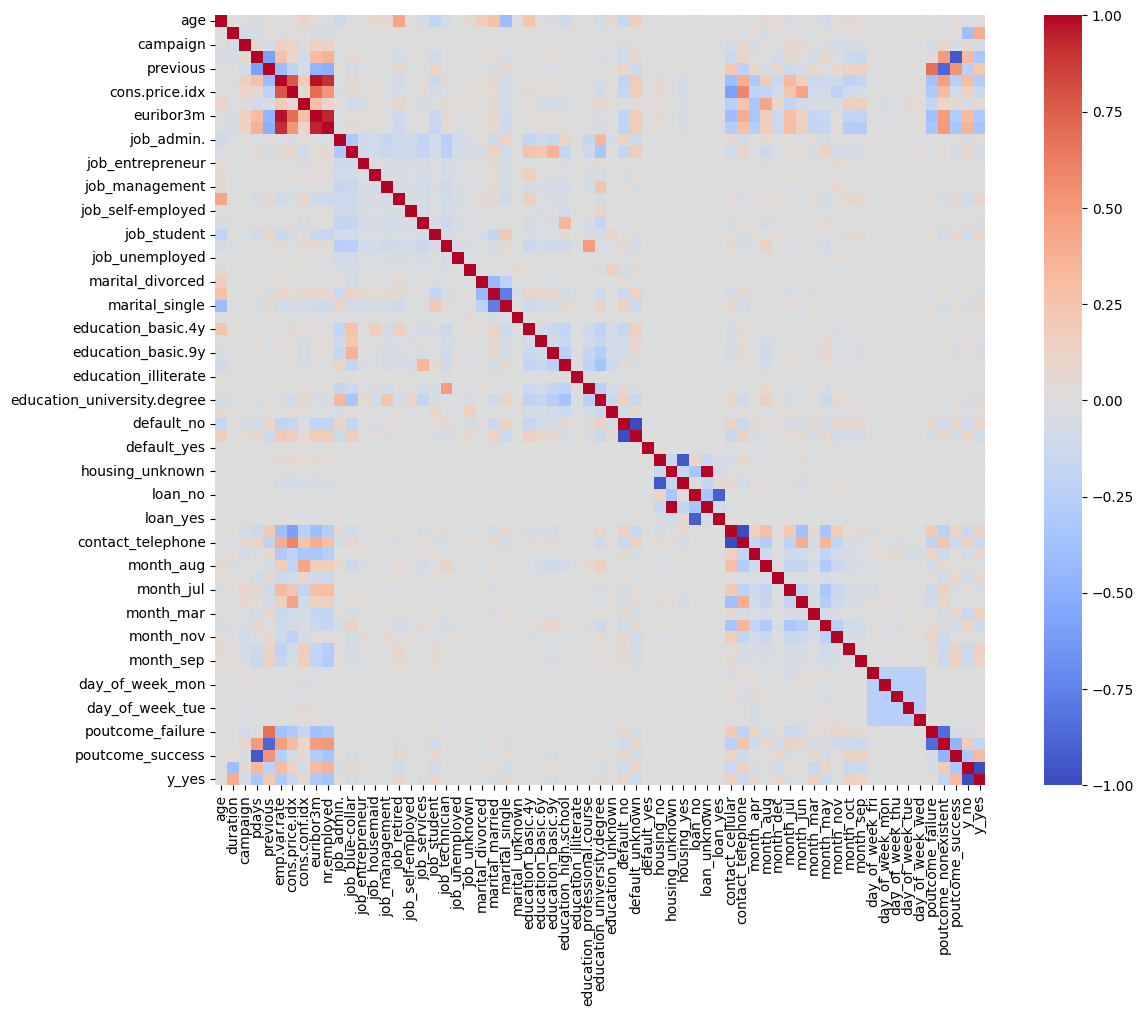

In [61]:
plt.figure(figsize=(15, 10))
sns.heatmap(df_corr, annot=False, cmap='coolwarm', square=True)
plt.show()